# Dataset characterization

In [35]:
import jsonlines
from os import listdir
from os.path import splitext
from collections import defaultdict, Counter
import sys
sys.path.append('../../desiccation-network/desiccation_network/build_citation_network/')
from descriptive_stats import get_per_class_cumulative_years
import numpy as np
import matplotlib.pyplot as plt

## Read in data

In [2]:
with jsonlines.open('../data/wos_files/drought_and_desiccation_combined_22Mar2024.jsonl') as reader:
    full_dataset = [obj for obj in reader]

Remove documents that didn't make it to the final dataset:

In [7]:
final_names = [splitext(f)[0] for f in listdir('/mnt/scratch/lotrecks/drought_and_desiccation_combined_22Mar2024/')]
full_dataset = [doc for doc in full_dataset if doc['UID'] in final_names]

In [10]:
uid2doc = {doc['UID']: doc for doc in full_dataset}

## Characterize

In [9]:
drought_only = []
desc_only = []
both = []
for doc in full_dataset:
    if doc['is_drought']:
        if doc['is_desiccation']:
            both.append(doc['UID'])
        else:
            drought_only.append(doc['UID'])
    else:
        if doc['is_desiccation']:
            desc_only.append(doc['UID'])
print(f'{len(drought_only)} documents are drought-only, {len(desc_only)} are desiccation-only, and {len(both)} belong to both datasets, for a total of {len(full_dataset)} documents.')

76260 documents are drought-only, 4622 are desiccation-only, and 1004 belong to both datasets, for a total of 81886 documents.


In [15]:
docs_per_year = defaultdict(list)
for name, uids in {'Drought only': drought_only, 'Desiccation only': desc_only, 'Both': both}.items():
    for doc in uids:
        docs_per_year[name].append(uid2doc[doc]['year'])

In [21]:
colors = {'Drought only': 'forestgreen', 'Desiccation only': 'darkgoldenrod', 'Both': 'cornflowerblue'}

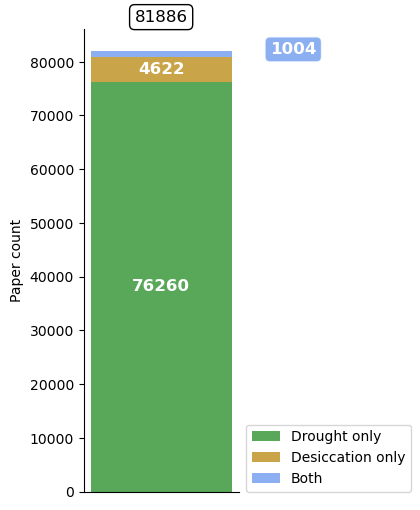

In [79]:
bottom = np.zeros(1)
fig, ax = plt.subplots(figsize=(2,6))
for cls, papers in docs_per_year.items():
    count = len(papers)
    ax.bar('Dataset', count, color=colors[cls], label=cls, bottom=bottom, alpha=0.75)
    bottom += count
    
for bar in ax.patches:
    if int(bar.get_height()) == 1004:
        both_y =  bar.get_y()
        top_y = bar.get_height() + both_y
        continue
    else:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            0.5*bar.get_height() + bar.get_y(),
            int(bar.get_height()),
            ha='center',
            va='center',
            color='w',
            weight='bold',
            size=12
        )
        centered_x = bar.get_x() + bar.get_width() / 2
        top_y = bar.get_height() + bar.get_y()

ax.text(0.75, both_y, len(docs_per_year['Both']), bbox={'boxstyle':'round', 'facecolor':colors['Both'], 'alpha': 0.75, 'edgecolor':'w'}, ha='center', va='bottom', fontsize=12, color='w', weight='bold')
ax.text(centered_x, top_y + 5000, sum([len(v) for v in docs_per_year.values()]), bbox={'boxstyle':'round', 'facecolor':'w'}, ha='center', va='bottom', fontsize=12)
ax.set_ylabel('Paper count')
ax.spines[['right', 'top']].set_visible(False)
ax.get_xaxis().set_visible(False)
_ = plt.legend(loc=(1.05,0))
plt.savefig('../data/figures/dataset_by_category_barplot.pdf', format='pdf', dpi=600, bbox_inches='tight')

In [19]:
cum_docs_per_year = get_per_class_cumulative_years(docs_per_year)

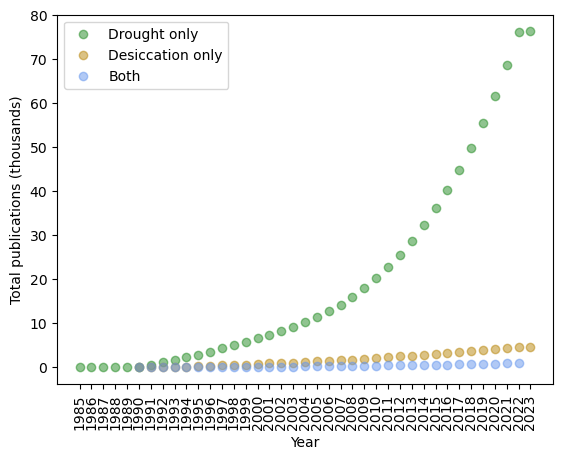

In [33]:
fig, ax = plt.subplots(1, 1)
for cls, cumulative_years in cum_docs_per_year.items():
        ax.scatter(cumulative_years.keys(),
                   cumulative_years.values(),
                   color=colors[cls],
                   alpha=0.5,
                   label=cls)
plt.legend()
plt.xticks(rotation=90)
plt.ylabel('Total publications (thousands)')
plt.xlabel('Year')
plt.savefig('../data/figures/dataset_cumulative_pubs_per_year.pdf', format='pdf', dpi=600, bbox_inches='tight')